In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
import pickle
import matplotlib as mpl
from salishsea_tools import evaltools as et
fs=14
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#from NorthNut import vvl_interp_T_to_V, vvl_interp_T_to_U;

%matplotlib inline

### Rivers:

In [2]:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
(timesRiverx,sumSilSOGRiversx,sumSilFraserx,sumNO3SOGRiversx,sumNO3Fraserx,sumNH4SOGRiversx,\
     sumNH4Fraserx)=pickle.load(open('../../save/rivFluxesNoInterp20150101-20180101.pkl','rb'))
(timesRiver,sumSilSOGRivers,sumSilFraser,sumNO3SOGRivers,sumNO3Fraser,sumNH4SOGRivers,\
     sumNH4Fraser)=pickle.load(open('../../save/rivFluxes20150101-20180101.pkl','rb'))
(timesHRiver,sumSilSOGRiversH,sumSilFraserH,sumNO3SOGRiversH,sumNO3FraserH,sumNH4SOGRiversH,\
     sumNH4FraserH)=pickle.load(open('../../save/rivFluxesHrly20150101-20180101.pkl','rb'))

In [4]:
(np.sum(sumSilSOGRiversx[1:360])-np.sum(sumSilSOGRivers[1:360]))/np.sum(sumSilSOGRiversx[1:360])

-1.7041091826502515e-06

Text(0, 0.5, 'mol N /day')

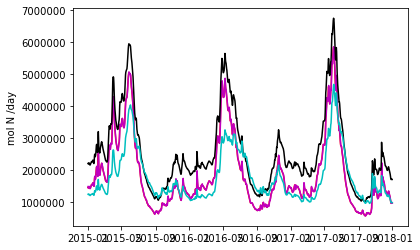

In [5]:
plt.plot(timesRiver,sumNO3Fraser,'r-')
plt.plot(timesHRiver,sumNO3FraserH*24,'m-')
plt.plot(timesRiver,sumNO3SOGRivers,'k-')
plt.plot(timesRiver,sumNH4SOGRivers,'c-')
plt.ylabel('mol N /day')

### Content

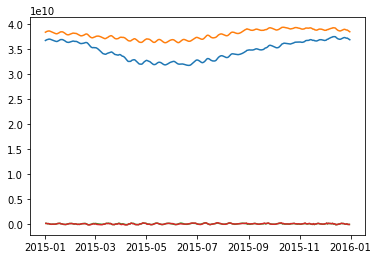

In [6]:
(timesContent,content)=pickle.load(open('../../save/SOGcontent20150101-20151231.pkl','rb'))
plt.plot(timesContent,content['NO3'])
contentTotN=content['NO3']+content['NH4']+content['DIAT']+content['FLAG']+content['MRUB']+\
        content['MICZ']+content['DON']+content['PON']
plt.plot(timesContent,contentTotN)
dNdt=contentTotN[1:]-contentTotN[:-1]
dNO3dt=content['NO3'][1:]-content['NO3'][:-1]
plt.plot([dt.timedelta(hours=12)+ii for ii in timesContent[:-1]],dNdt)
plt.plot([dt.timedelta(hours=12)+ii for ii in timesContent[:-1]],dNO3dt)

### bio rates

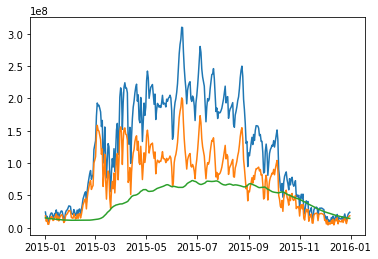

In [7]:
(timesRates,rates)=pickle.load(open('../../save/SOGrates20150101-20151231.pkl','rb'))
plt.plot(timesRates,rates['PP'])
plt.plot(timesRates,rates['NPP'])
plt.plot(timesRates,rates['NHtoNO'])

### sinking

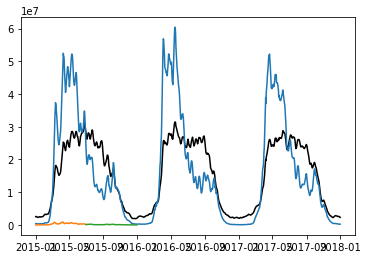

In [8]:
csinkPath='../../save/SOGsinkPONbSi20150101-20171231.pkl'
(timesSink,sink)=pickle.load(open(csinkPath,'rb'))
dsinkPatha='../../save/SOGsinkDiat20150101-20150630.pkl'
dsinkPathb='../../save/SOGsinkDiat20150701-20151231.pkl'
(timesSinkDa,sinkDa)=pickle.load(open(dsinkPatha,'rb'))
(timesSinkDb,sinkDb)=pickle.load(open(dsinkPathb,'rb'))
plt.plot(timesSink,sink['PON'],'k-')
plt.plot(timesSink,sink['BSI'])
plt.plot(timesSinkDa,sinkDa)
plt.plot(timesSinkDb,sinkDb)
sinkdiat=np.concatenate((sinkDa,sinkDb))
timesSinkdiat=np.concatenate((timesSinkDa,timesSinkDb))

In [9]:
np.sum(sink['PON'])*1e-9,np.sum(sink['BSI'])*1e-9,np.sum(sink['BSI'])/np.sum(sink['PON'])

(16.779469554192705, 17.89818633041903, 1.0666717605472094)

In [10]:
# check order of magnitude:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))
SOGmask=tmaskSOG[:,:,jg0:jg1,ig0:ig1]
dcmask=np.zeros_like(SOGmask)
dcmask[:,:-1,:,:]=SOGmask[:,:-1,:,:]-SOGmask[:,1:,:,:]
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    A=np.expand_dims(fm.variables['e1t'][:,jg0:jg1,ig0:ig1]*fm.variables['e2t'][:,jg0:jg1,ig0:ig1],0)
alpha=0.8
wdiat=.5/(24*3600)
wbsi= 1.3e-4   
with nc.Dataset('/results2/SalishSea/nowcast-green.201812/01may15/SalishSea_1d_20150501_20150501_ptrc_T.nc') as f:
    print('diatoms:',
        1e-3*24*3600*(1.0-alpha)*wdiat*np.sum(A*dcmask*f.variables['diatoms'][0,:,jg0:jg1,ig0:ig1]),
                                np.sum(A*dcmask*f.variables['diatoms'][0,:,jg0:jg1,ig0:ig1]))
    print('bsi:',
        1e-3*24*3600*(1.0-alpha)*wbsi*np.sum(A*dcmask*f.variables['biogenic_silicon'][0,:,jg0:jg1,ig0:ig1]),
                                np.sum(A*dcmask*f.variables['biogenic_silicon'][0,:,jg0:jg1,ig0:ig1]))
print('wdiat:',wdiat,' -> difference in sinking velocities leads to order of magnitude difference in fluxes')

diatoms: 416577.41368316545 4165774136.8316555
bsi: 43992586.359814644 19583594355.330597
wdiat: 5.787037037037037e-06  -> difference in sinking velocities leads to order of magnitude difference in fluxes


### boundaries

dict_keys(['SJDFK', 'SJDFW', 'SJDFE', 'Malaspina'])
dict_keys(['Haro', 'SJC', 'Rosario', 'Discovery', 'Sutil'])
dict_keys(['diatoms', 'flagellates', 'ciliates', 'ammonium', 'silicon', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'nitrate'])


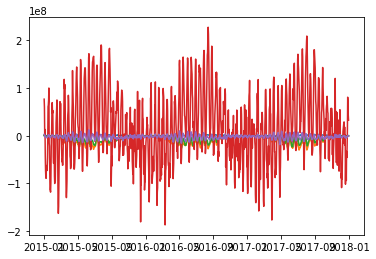

In [11]:
boundPath='../../save/transpLinesAllVars1dFiles20150101-20171231.pkl'
data=pickle.load(open(boundPath,'rb'))
mod_start=data['mod_start']
mod_end= data['mod_end']
timesBound=np.array([mod_start+dt.timedelta(days=ii) for ii in range(0,int(1+(mod_end-mod_start).total_seconds()/(24*3600)))])
Tr =data['Tr']
ulines=data['ulines']
vlines=data['vlines']
print(ulines.keys())
print(vlines.keys())
print(Tr.keys())
# south is positive in for all
southernLiving=Tr['diatoms']['Haro']+Tr['diatoms']['SJC']+Tr['diatoms']['Rosario']+\
    Tr['flagellates']['Haro']+Tr['flagellates']['SJC']+Tr['flagellates']['Rosario']+\
    Tr['ciliates']['Haro']+Tr['ciliates']['SJC']+Tr['ciliates']['Rosario']+\
    Tr['microzooplankton']['Haro']+Tr['microzooplankton']['SJC']+Tr['microzooplankton']['Rosario']
southernNLO=Tr['dissolved_organic_nitrogen']['Haro']+Tr['dissolved_organic_nitrogen']['SJC']+Tr['dissolved_organic_nitrogen']['Rosario']+\
    Tr['particulate_organic_nitrogen']['Haro']+Tr['particulate_organic_nitrogen']['SJC']+Tr['particulate_organic_nitrogen']['Rosario']
southernNO3=Tr['nitrate']['Haro']+Tr['nitrate']['SJC']+Tr['nitrate']['Rosario'] # positive in
southernNH4=Tr['ammonium']['Haro']+Tr['ammonium']['SJC']+Tr['ammonium']['Rosario']

#north is positive out for all
northernLiving=Tr['diatoms']['Malaspina']+Tr['diatoms']['Sutil']+Tr['diatoms']['Discovery']+\
    Tr['flagellates']['Malaspina']+Tr['flagellates']['Sutil']+Tr['flagellates']['Discovery']+\
    Tr['ciliates']['Malaspina']+Tr['ciliates']['Sutil']+Tr['ciliates']['Discovery']+\
    Tr['microzooplankton']['Malaspina']+Tr['microzooplankton']['Sutil']+Tr['microzooplankton']['Discovery']
northernNLO=Tr['dissolved_organic_nitrogen']['Malaspina']+Tr['dissolved_organic_nitrogen']['Sutil']+Tr['dissolved_organic_nitrogen']['Discovery']+\
    Tr['particulate_organic_nitrogen']['Malaspina']+Tr['particulate_organic_nitrogen']['Sutil']+Tr['particulate_organic_nitrogen']['Discovery']
northernNO3=Tr['nitrate']['Malaspina']+Tr['nitrate']['Sutil']+Tr['nitrate']['Discovery']
northernNH4=Tr['ammonium']['Malaspina']+Tr['ammonium']['Sutil']+Tr['ammonium']['Discovery']

plt.plot(timesBound,Tr['particulate_organic_nitrogen']['Haro'])
plt.plot(timesBound,southernLiving)
plt.plot(timesBound,southernNLO)
plt.plot(timesBound,southernNO3)
plt.plot(timesBound,southernNH4)

In [12]:
datatest=pickle.load(open('../../save/transpLines20150101-20151231.pkl','rb'))

In [13]:
np.shape(datatest['no3T']['Haro'])

(8760, 40, 33)

In [14]:
transpsum=np.sum(np.sum(datatest['no3T']['Haro'],2),1)
transpcor=list()
for ii in range(0,int(len(datatest['no3T']['Haro'])/24)):
    transpcor.append(1e-3*3600*np.sum(transpsum[ii*24:(ii+1)*24]))
transpcor=np.array(transpcor)

In [15]:
np.mean(transpsum)*1e-3*24*3600

64478274.765349016

In [16]:
np.mean(transpcor)*365*1e-9

23.53457028935239

(0, 365)

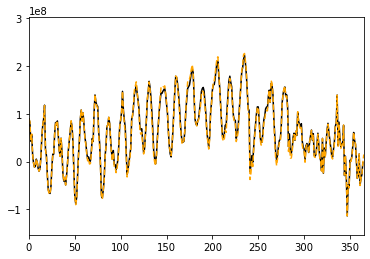

In [17]:
# compare daily and hourly calc'd transports
plt.plot(transpcor,'k-')# mmol/s*1e-3*24*3600=mol/day
plt.plot(Tr['nitrate']['Haro'],'--',color='orange')
plt.xlim(0,365)

In [18]:
# difference in Haro NO3 transport, hourly vs daily calcs
np.sum(transpcor[:365]),np.sum(Tr['nitrate']['Haro'][:365])

(23534570289.35239, 22812817036.37513)

Mixing

In [19]:
dmJF=pickle.load(open('/data/eolson/save/transpLines20150101-20150228.pkl','rb'))
dmMA=pickle.load(open('/data/eolson/save/transpLines20150301-20150430.pkl','rb'))
dmMJ=pickle.load(open('/data/eolson/save/transpLines20150501-20150630.pkl','rb'))
dmJAS=pickle.load(open('/data/eolson/save/transpLines20150701-20150930.pkl','rb'))
dmOND=pickle.load(open('/data/eolson/save/transpLines20151001-20151231.pkl','rb'))

In [20]:
mix=dict()
for path in dmJF['no3TMix'].keys():
    mix[path]=np.concatenate((np.sum(np.sum(dmJF['no3TMix'][path],2),1),
                              np.sum(np.sum(dmMA['no3TMix'][path],2),1),
                              np.sum(np.sum(dmMJ['no3TMix'][path],2),1),
                              np.sum(np.sum(dmJAS['no3TMix'][path],2),1),
                             np.sum(np.sum(dmOND['no3TMix'][path],2),1)))


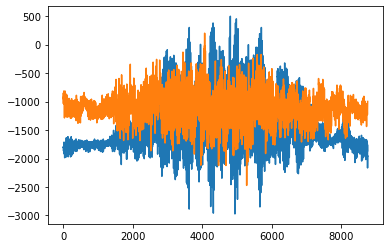

In [52]:
plt.plot(mix['Haro']+mix['SJC']+mix['Rosario'])
plt.plot(mix['Discovery']+mix['Sutil']+mix['Malaspina'])

In [57]:
np.sum(mix['Haro']+mix['SJC']+mix['Rosario'])*3600*1e-3*1e-9

-0.04492855820773604

In [56]:
np.sum(mix['Discovery']+mix['Sutil']+mix['Malaspina'])*3600*1e-3*1e-9

-0.034693629827570335

In [58]:
# total mixing effect:
np.sum(mix['Haro']+mix['SJC']+mix['Rosario'])*3600*1e-3*1e-9-np.sum(mix['Discovery']+mix['Sutil']+mix['Malaspina'])*3600*1e-3*1e-9

-0.010234928380165702

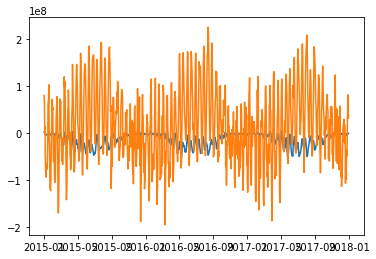

In [23]:
plt.plot(timesBound,southernLiving+southernNLO)
plt.plot(timesBound,southernNO3+southernNH4)

### check sums

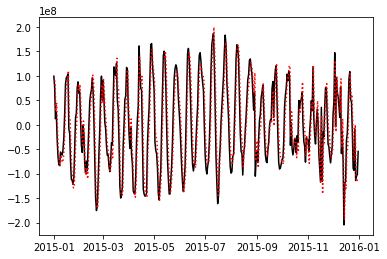

In [24]:
# note: flux estimates not exact because some calculated based on daily mean fields
changeEst2015=sumNO3SOGRivers[:365]+sumNH4SOGRivers[:365]\
            -sinkdiat-sink['PON'][:365]\
            +southernLiving[:365]+southernNLO[:365]+southernNO3[:365]+southernNH4[:365]\
            -northernLiving[:365]-northernNLO[:365]-northernNO3[:365]-northernNH4[:365] 
plt.plot(timesBound[:365],changeEst2015,'k-')
plt.plot([dt.timedelta(hours=12)+ii for ii in timesContent[:-1]],dNdt,'r:')

In [25]:
print('rivers:',np.sum(sumNO3SOGRivers[:365]+sumNH4SOGRivers[:365])*1e-9, '10^9 mol/yr')
print('sinking:',-1*np.sum(sinkdiat+sink['PON'][:365])*1e-9, '10^9 mol/yr')
print('S boundary:',np.sum(southernLiving[:365]+southernNLO[:365]+southernNO3[:365]+southernNH4[:365])*1e-9, '10^9 mol/yr')
print('N boundary:',-1*np.sum(northernLiving[:365]+northernNLO[:365]+northernNO3[:365]+northernNH4[:365])*1e-9, '10^9 mol/yr')

rivers: 1.6409145606229112 10^9 mol/yr
sinking: -5.878863129902062 10^9 mol/yr
S boundary: 0.35804672662746145 10^9 mol/yr
N boundary: 3.486321667195588 10^9 mol/yr


In [26]:
print('net change based on summed rates:',np.sum(sumNO3SOGRivers[:365]+sumNH4SOGRivers[:365])*1e-9+\
    -1*np.sum(sinkdiat+sink['PON'][:365])*1e-9+\
        np.sum(southernLiving[:365]+southernNLO[:365]+southernNO3[:365]+southernNH4[:365])*1e-9+\
            -1*np.sum(northernLiving[:365]+northernNLO[:365]+northernNO3[:365]+northernNH4[:365])*1e-9,'10^9 mol/yr')

net change based on summed rates: -0.3935801754561017 10^9 mol/yr


In [27]:
print('net change based on content:',(contentTotN[-1]-contentTotN[0])*1e-9,'10^9 mol/yr')

net change based on content: 0.09532592453204346 10^9 mol/yr


In [28]:
np.sum(dNdt*1e-9)

0.09532592453204347

In [29]:
print('S Boundary nitrate:',np.sum(southernNO3[:365])*1e-9,'10^9 mol/yr')
print('Haro nitrate:',np.sum(Tr['nitrate']['Haro'][:365])*1e-9,'10^9 mol/yr')
print('Sutton Haro nitrate:',29900*1e6*1e-9,'10^9 mol/yr')

S Boundary nitrate: 6.608296214033555 10^9 mol/yr
Haro nitrate: 22.81281703637513 10^9 mol/yr
Sutton Haro nitrate: 29.900000000000002 10^9 mol/yr


In [30]:
print('S boundary:',np.sum(southernNO3[:365])*1e-9, '10^9 mol/yr')


S boundary: 6.608296214033555 10^9 mol/yr


In [31]:
np.sum(southernNLO[:365])*1e-9

-2.120632202273965

In [32]:
np.sum(southernLiving[:365])*1e-9

-3.1220730036543656

In [33]:
(contentTotN[-1]-contentTotN[0])*1e-9

0.09532592453204346

In [34]:
1.64+1.24-0.65

2.23

In [35]:
1662*10**6*1e-9

1.6620000000000001

In [36]:
print('rivers:',np.sum(sumNO3SOGRivers[:365]+sumNH4SOGRivers[:365])*1e-9, '10^9 mol/yr')
print('Sutton river DIN estimate:',(1662+37)*1e6*1e-9,'10^9 mol/yr')
print('-')
print('sinking:',-1*np.sum(sinkdiat+sink['PON'][:365])*1e-9, '10^9 mol/yr')
print('Sutton particulate flux to sediment:',-1*(490+1860)*1e6*1e-9,'10^9 mol/yr')
print('NO3 flux from sediment:',0)
print('Sutton DIN flux from sediment due to remineralized PP:',350*1e6*1e-9,'10^9 mol/yr')
print('-')
print('Haro nitrate:',np.sum(Tr['nitrate']['Haro'][:365])*1e-9,'10^9 mol/yr')
print('Sutton Haro nitrate:',29900*1e6*1e-9,'10^9 mol/yr')
print('Total Southern Passages nitrate:',np.sum(southernNO3[:365])*1e-9,'10^9 mol/yr')
print('All Southern Passage DIN:',np.sum(southernNO3[:365]+southernNH4[:365])*1e-9,'10^9 mol/yr')

rivers: 1.6409145606229112 10^9 mol/yr
Sutton river DIN estimate: 1.699 10^9 mol/yr
-
sinking: -5.878863129902062 10^9 mol/yr
Sutton particulate flux to sediment: -2.35 10^9 mol/yr
NO3 flux from sediment: 0
Sutton DIN flux from sediment due to remineralized PP: 0.35000000000000003 10^9 mol/yr
-
Haro nitrate: 22.81281703637513 10^9 mol/yr
Sutton Haro nitrate: 29.900000000000002 10^9 mol/yr
Total Southern Passages nitrate: 6.608296214033555 10^9 mol/yr
All Southern Passage DIN: 5.600751932555792 10^9 mol/yr


In [37]:
print('rivers DIN 2015:',np.sum(sumNO3SOGRivers[365:(365*2+1)]+sumNH4SOGRivers[365:(365*2+1)])/(24*3600*365), ' mol/s')
print('rivers DIN 2016:',np.sum(sumNO3SOGRivers[365:(365*2+1)]+sumNH4SOGRivers[365:(365*2+1)])/(24*3600*365), ' mol/s')
print('rivers DIN 2018:',np.sum(sumNO3SOGRivers[(365*2+1):(365*3+1)]+sumNH4SOGRivers[(365*2+1):(365*3+1)])/(24*3600*365), ' mol/s')

rivers DIN 2015: 50.89527456722993  mol/s
rivers DIN 2016: 50.89527456722993  mol/s
rivers DIN 2018: 49.08157855269846  mol/s


### nitrate budget

In [38]:
print('rivers:',np.sum(sumNO3SOGRivers[:365])*1e-9, '10^9 mol/yr')
print('Sutton DIN rivers:',1700*1e6*1e-9, '10^9 mol/yr')
print('Total Southern Passages nitrate:',np.sum(southernNO3[:365])*1e-9,'10^9 mol/yr')
print('Total Northern Passages nitrate:',-1*np.sum(northernNO3[:365])*1e-9,'10^9 mol/yr')
print('Total Uptake nitrate by PP:',-1*np.sum(rates['NPP'][:365])*1e-9,'10^9 mol/yr')
print('Sutton PP:',-23400*1e6*1e-9, '10^9 mol/yr')
print('Total NH4->NO3:',np.sum(rates['NHtoNO'][:365])*1e-9,'10^9 mol/yr')
print('Sutton remin:',22000*1e6*1e-9, '10^9 mol/yr')

rivers: 0.9737098789302925 10^9 mol/yr
Sutton DIN rivers: 1.7000000000000002 10^9 mol/yr
Total Southern Passages nitrate: 6.608296214033555 10^9 mol/yr
Total Northern Passages nitrate: 2.3331054847561776 10^9 mol/yr
Total Uptake nitrate by PP: -26.54286351784903 10^9 mol/yr
Sutton PP: -23.400000000000002 10^9 mol/yr
Total NH4->NO3: 16.101295937442163 10^9 mol/yr
Sutton remin: 22.0 10^9 mol/yr


In [39]:
print('rivers NO3 2015:',np.sum(sumNO3SOGRivers[:365])/(24*3600*365), 'mol/s')
print('rivers NO3 2016:',np.sum(sumNO3SOGRivers[365:(365*2+1)])/(24*3600*365), 'mol/s')
print('rivers NO3 2017:',np.sum(sumNO3SOGRivers[(365*2+1):(365*3+1)])/(24*3600*365), 'mol/s')

rivers NO3 2015: 30.87613771341617 mol/s
rivers NO3 2016: 29.958000318682814 mol/s
rivers NO3 2017: 28.781811094320634 mol/s


In [40]:
print('rivers:',np.sum(sumNO3SOGRivers[:365])*1e-9, '10^9 mol/yr')
print('Total Southern Passages nitrate:',np.sum(southernNO3[:365])*1e-9,'10^9 mol/yr')
print('Total Northern Passages nitrate:',-1*np.sum(northernNO3[:365])*1e-9,'10^9 mol/yr')
print('Total Uptake nitrate by PP:',-1*np.sum(rates['NPP'][:365])*1e-9,'10^9 mol/yr')
print('Total NH4->NO3:',np.sum(rates['NHtoNO'][:365])*1e-9,'10^9 mol/yr')

rivers: 0.9737098789302925 10^9 mol/yr
Total Southern Passages nitrate: 6.608296214033555 10^9 mol/yr
Total Northern Passages nitrate: 2.3331054847561776 10^9 mol/yr
Total Uptake nitrate by PP: -26.54286351784903 10^9 mol/yr
Total NH4->NO3: 16.101295937442163 10^9 mol/yr


In [41]:
#with daily transports:
np.sum(sumNO3SOGRivers[:365])*1e-9+\
    np.sum(southernNO3[:365])*1e-9+\
        -1*np.sum(northernNO3[:365])*1e-9+\
            -1*np.sum(rates['NPP'][:365])*1e-9+\
                np.sum(rates['NHtoNO'][:365])*1e-9

-0.5264560026868459

In [42]:
# Hourly transports
southernNO3_Haro=np.mean(np.sum(np.sum(datatest['no3T']['Haro'],2),1),0)*3600*24*365*1e-3
southernNO3_SJC=np.mean(np.sum(np.sum(datatest['no3T']['SJC'],2),1),0)*3600*24*365*1e-3
southernNO3_Ros=np.mean(np.sum(np.sum(datatest['no3T']['Rosario'],2),1),0)*3600*24*365*1e-3
southernNO3_Haro*1e-9,southernNO3_SJC*1e-9,southernNO3_Ros*1e-9

(23.53457028935239, -2.625900348334705, -11.70163728417709)

In [43]:
# Hourly transports- North
northernNO3_Disc=np.mean(np.sum(np.sum(datatest['no3T']['Discovery'],2),1),0)*3600*24*365*1e-3
northernNO3_Sutil=np.mean(np.sum(np.sum(datatest['no3T']['Sutil'],2),1),0)*3600*24*365*1e-3
nothernNO3_Mal=np.mean(np.sum(np.sum(datatest['no3T']['Malaspina'],2),1),0)*3600*24*365*1e-3
northernNO3_Disc*1e-9,northernNO3_Sutil*1e-9,nothernNO3_Mal*1e-9

(-1.4891602298452395, 5.118870759898599, -4.999020785799128)

In [44]:
print('rivers:',np.sum(sumNO3SOGRivers[:365])*1e-9, '10^9 mol/yr')
print('Total Southern Passages nitrate hrly:',(southernNO3_Haro+southernNO3_SJC+southernNO3_Ros)*1e-9,'10^9 mol/yr')
print('Total Northern Passages nitrate hrly:',-1*(northernNO3_Disc+northernNO3_Sutil+nothernNO3_Mal)*1e-9,'10^9 mol/yr')
print('Total Uptake nitrate by PP:',-1*np.sum(rates['NPP'][:365])*1e-9,'10^9 mol/yr')
print('Total NH4->NO3:',np.sum(rates['NHtoNO'][:365])*1e-9,'10^9 mol/yr')

rivers: 0.9737098789302925 10^9 mol/yr
Total Southern Passages nitrate hrly: 9.207032656840596 10^9 mol/yr
Total Northern Passages nitrate hrly: 1.3693102557457686 10^9 mol/yr
Total Uptake nitrate by PP: -26.54286351784903 10^9 mol/yr
Total NH4->NO3: 16.101295937442163 10^9 mol/yr


In [45]:
# Daily transports
np.sum(Tr['nitrate']['Haro'][:365])*1e-9,np.sum(Tr['nitrate']['SJC'][:365])*1e-9,np.sum(Tr['nitrate']['Rosario'][:365])*1e-9

(22.81281703637513, -2.7428710994888736, -13.461649722852702)

In [46]:
# with hourly transports
np.sum(sumNO3SOGRivers[:365])*1e-9+\
    southernNO3_Haro*1e-9+southernNO3_SJC*1e-9+southernNO3_Ros*1e-9+\
        -northernNO3_Disc*1e-9-northernNO3_Sutil*1e-9-nothernNO3_Mal*1e-9+\
            -1*np.sum(rates['NPP'][:365])*1e-9+\
                np.sum(rates['NHtoNO'][:365])*1e-9

1.1084852111097874

In [47]:
np.sum(rates['NPP'][:365])*1e-9

26.54286351784903

In [48]:
# actual change in content (includes e3t in calcs):
(content['NO3'][-1]-content['NO3'][0])*1e-9

0.1538940777856598

In [49]:
0.2919530903361427*1e-3*24*3600*1e-9
#kmol/s *1e-3*1e-9 *24*3600 

2.5224747005042733e-08

In [50]:
0.2919530903361427*1e3*24*3600*365*1e-9

9.207032656840596